## AIC Calcium data analysis

## Settings

In [1]:
# In case of artifacts, cut off from start or end (in s):
CutStart = 0
CutEnd = 0

# Time resolution after downsampling in s:
tres_new = 0.01

# Plot size
plotsize = (15,10)  # typically 10 to 15 is ok.


#-- Settings for average response plots:

baseline = 5 # baseline to consider before each block, 10
_time = 15 # how many seconds to display after stim block ends, 30


#-- AFNI regressors
bsl = 60   # seconds to include before first stimulus event

#-- Create output files?
create_output = True  # True or False


#-- Advanced Settings
# mod_ch1 = 1230  # <-- Enter the mod. freq. manually if automatic detection fails.
# mod_ch2 = 980

xSTD = 5  # How many standard deviations to consider a signal "jump/drop" in the data?
secstoconsider = 2 # How many seconds before and after a signal jump should be compared?


## Import libraries

In [1]:
import os, sys, pathlib
mymodules = os.fspath(pathlib.Path.cwd().joinpath('CustomModules'))
if mymodules not in sys.path:
    sys.path.append(mymodules)
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from nptdms import TdmsFile
import pandas as pd
import plotly as py
import plotly.graph_objs as go
import calciumHelperfunctions as h
import importlib
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

plt.style.use('seaborn-white')
%matplotlib inline

py.offline.init_notebook_mode(connected=True)

h = importlib.reload(h)

## Importing Labview recordings

In [3]:
file_path = h.openfiledialogue('.tdms')
data_path = os.path.dirname(file_path)

tdms_file = TdmsFile(file_path)

all_channels = tdms_file.group_channels(tdms_file.groups()[0])


fs = round(1/all_channels[0].properties['wf_increment'])
N = all_channels[0].number_values

time_sec = np.arange(1/fs,N/fs+1/fs,1/fs)

index = pd.Index(time_sec, name=['originalTime'])
columns = pd.MultiIndex.from_product([['channel1','channel2'],['raw','sin_ref','cos_ref','demod_sin','demod_cos','demod_sin_filtered','demod_cos_filtered','demod_tot']],names=['channel','step'])

# create empty DataFrame
calcium = pd.DataFrame(np.zeros((index.size,columns.size)),index = index, columns = columns)

# Fill in some columns
calcium['channel1','raw'] = -tdms_file.channel_data(tdms_file.groups()[0], "RCaMP")  
calcium['channel2','raw'] = -tdms_file.channel_data(tdms_file.groups()[0], "GCaMP")  # minus because AIC amplifier doesnt produces negative voltage signal.
calcium = calcium.sort_index()

try:
    stimdata = {'Stimulus' : tdms_file.channel_data(tdms_file.groups()[0], "Stimulus"),
               'Inhibition' : tdms_file.channel_data(tdms_file.groups()[0], "Inhibition")}
except:
    stimdata = {'Stimulus' : tdms_file.channel_data(tdms_file.groups()[0], "Stimulus")}
stimchannels = pd.DataFrame(stimdata, index=index)

calcium = calcium.iloc[int(CutStart*fs):int(len(calcium)-CutEnd*fs),:]
stimchannels = stimchannels.iloc[int(CutStart*fs):int(len(stimchannels)-CutEnd*fs),:]

#used later to store .mat file, regressors, and plots
matfilename=os.path.splitext(os.path.basename(file_path))[0]
storagepath=os.path.join(os.path.abspath(data_path),matfilename)
if not os.path.exists(storagepath):
    os.makedirs(storagepath)

print (f'loaded {file_path}')
print (f'sampling rate is: {fs} Hz')

loaded D:/data/2018/6845_1.tdms
sampling rate is: 20000 Hz


## Basic Preprocessing

E:\GithubRepositories\Calcium\calciumHelperfunctions.py:76: RuntimeWarning:

divide by zero encountered in double_scalars



stim freq: 0.0 Hz
ON duration: inf s
OFF duration: 0.0 s
Signals slower than inf s will be removed (later)

channel 1 is RCaMP with mod. freq.: 1230.0 Hz
channel 2 is GCaMP with mod. freq.: 890.0 Hz


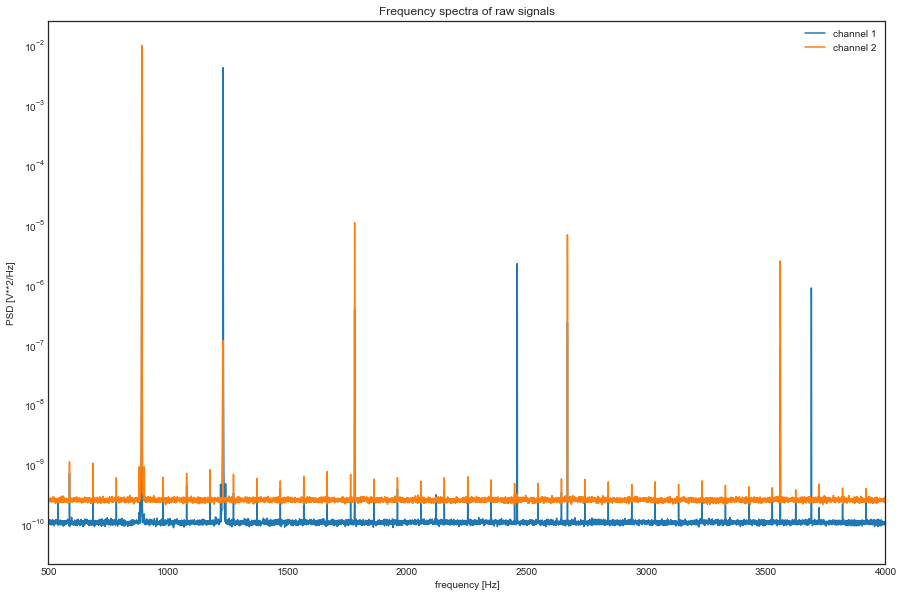

In [4]:
# get stimulus parameters  - check output below if correct, if not, set those variables manually
# (n_pulses, n_blocks, stim_freq, pulses_block,
#  block_duration, off_period, peakindexes_sec, peakindexes, period) = h.detect_stim_paradigm(stimchannel, fs)

paradigm = h.detect_stim_paradigm_TDMS(stimchannels, fs)


# Show a power spectrum - check if signals show correct peaks
mod_ch1, mod_ch2 = h.FFT_calculate_plot(calcium, fs, plotsize)

# double check if this output is correct
print(f'\nchannel 1 is RCaMP with mod. freq.: {str(mod_ch1)} Hz')
print(f'channel 2 is GCaMP with mod. freq.: {str(mod_ch2)} Hz')


#--- apply Demodulation ---
calcium, paradigm['peakindices_s'] = h.demodulate(calcium, mod_ch1, mod_ch2, fs, paradigm['peakindices_s'])


#--- Apply Downsampling ---
start = calcium.index[0]-CutStart
time_sec_ds = np.arange(start, h.downsamplebin(calcium['channel1','demod_tot'].values, tres_new, fs).size*tres_new+start-tres_new, tres_new)
_index = pd.Index(time_sec_ds, name=['downsampled time'])
columns = pd.MultiIndex.from_product([['channel1', 'channel2'],['downsampled_raw','baseline_fit','detrended']],names=['channel','step'])
calcium_ds = pd.DataFrame(np.zeros((_index.size, columns.size)), index=_index, columns = columns)
calcium_ds = calcium_ds.sort_index(axis=0)
calcium_ds = calcium_ds.sort_index(axis=1)
calcium_ds['channel1', 'downsampled_raw'] = h.downsamplebin(calcium['channel1','demod_tot'].values, tres_new, fs)[:calcium_ds.index.size]
calcium_ds['channel2', 'downsampled_raw'] = h.downsamplebin(calcium['channel2','demod_tot'].values, tres_new, fs)[:calcium_ds.index.size]

In [ ]:
# for single pulse stimulation

paradigm['n_pulses'] = 30
paradigm['n_blocks'] = paradigm['n_pulses']
paradigm['stim_freq'] = 1
paradigm['pulses_block'] = 1
paradigm['block_duration'] = 20
paradigm['off_duration'] = 19

paradigm['period'] = 2*(paradigm['off_duration'] + paradigm['off_duration'])

## Fixing jumps in data
Some short spikes may remain in the data. This is no problem, it will be averaged out in the downsampling procedure in the next cell.

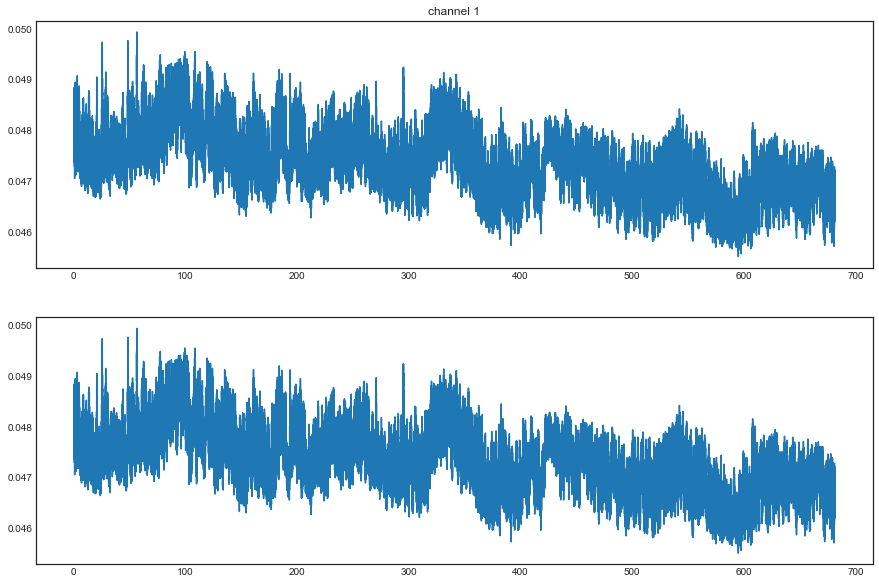

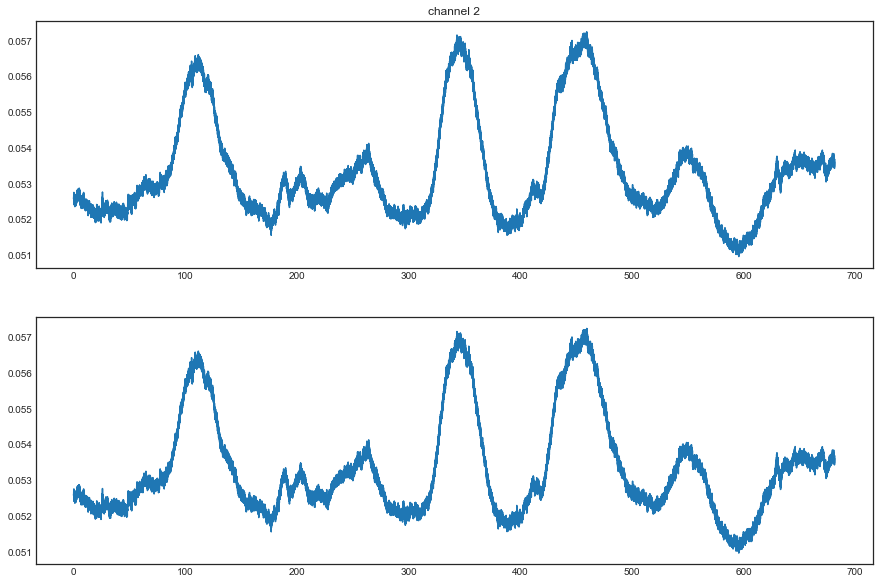

In [5]:
channel1_value = 6 #<--- How many SD does signal have to change one point to the next to be considered a "jump"
channel2_value = 6

calcium_ds['channel1','downsampled_fixed'] = h.fixjumps(calcium_ds['channel1', 'downsampled_raw'].values,calcium_ds.index.values, 'Ch1', fs=fs, tres_new=tres_new, xSTD=channel1_value)
calcium_ds['channel2','downsampled_fixed'] = h.fixjumps(calcium_ds['channel2', 'downsampled_raw'].values,calcium_ds.index.values, 'Ch2', fs=fs, tres_new=tres_new, xSTD=channel2_value)


plt.figure(figsize=plotsize)
plt.subplot(2, 1, 1)
plt.title('channel 1')
plt.plot(calcium_ds['channel1','downsampled_raw'])
plt.subplot(2, 1, 2)
plt.plot(calcium_ds['channel1','downsampled_fixed'])
plt.savefig(os.path.join(storagepath,'jumps_ch1.svg'))


plt.figure(figsize=plotsize)
plt.subplot(2, 1, 1)
plt.title('channel 2')
plt.plot(calcium_ds['channel2','downsampled_raw'])
plt.subplot(2, 1, 2)
plt.plot(calcium_ds['channel2','downsampled_fixed'])
plt.savefig(os.path.join(storagepath,'jumps_ch2.svg'))


## Detrending / Baseline drift removal

polynomial degree  1


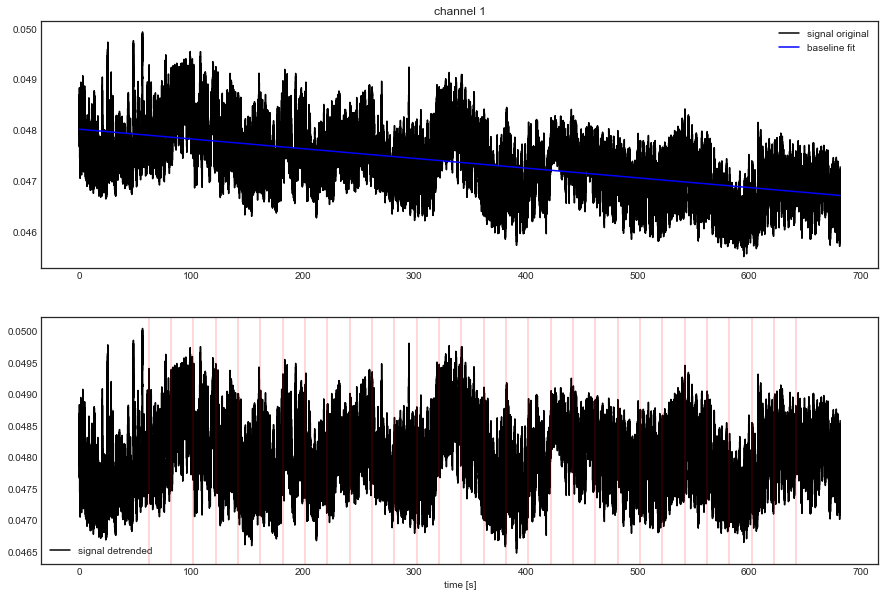

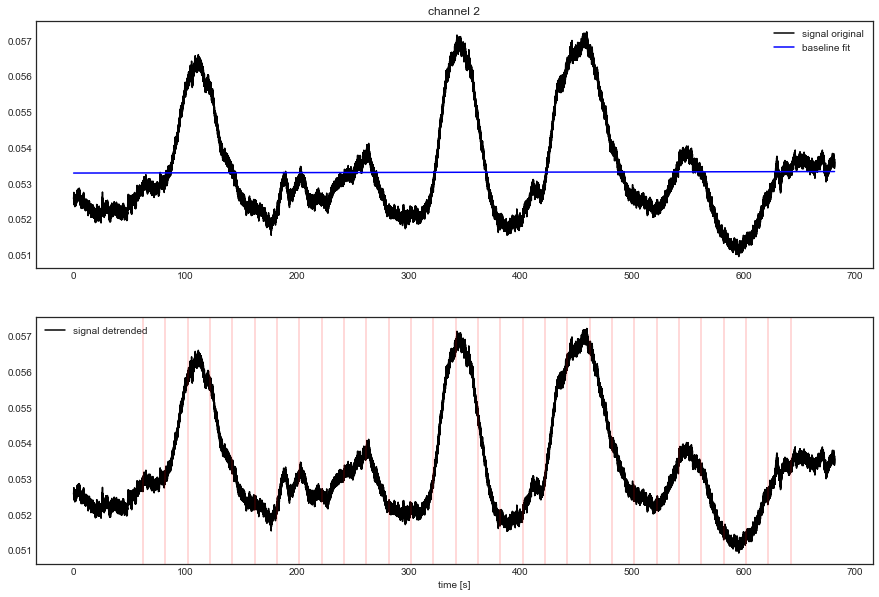

In [6]:
#find degree of polynomial (based on AFNI formula)
pnum = h.find_optimal_polynomial(calcium_ds, paradigm['period'])

# pnum=0 # <--  manually set polynomial degree here, or 0 to turn off detrending.

calcium_ds = h.calciumDetrend(calcium_ds, '1', pnum, plotsize, paradigm['peakindices_s'], storagepath)
calcium_ds = h.calciumDetrend(calcium_ds, '2', pnum, plotsize, paradigm['peakindices_s'], storagepath)

## Averaging stimulation blocks

In [7]:
blocks_perc_ch1 = h.average_and_plot_TDMS(calcium_ds, 'channel1', paradigm, baseline, _time, tres_new, storagepath)
blocks_perc_ch2 = h.average_and_plot_TDMS(calcium_ds, 'channel2', paradigm, baseline, _time, tres_new, storagepath)

E:\GithubRepositories\Calcium\calciumHelperfunctions.py:425: RuntimeWarning:

invalid value encountered in double_scalars



ValueError: cannot convert float NaN to integer

## Storing Response in Matlab file

Not tested yet. Will create a new .mat file each time in the same folder as the .lvm file.
Filename is the same as the .lvm file. More infos under https://docs.scipy.org/doc/scipy/reference/tutorial/io.html

Contents of the file are arranged like this:<br>
<br>
-Channel 1
    -  mean (of all blocks, in percent signal)
    -  SD (standard deviation across blocks)
    -  time (x axis)
    -  stim (stim pulses in seconds)
-Channel 2 
    -  mean (of all blocks, in percent signal)
    -  SD (standard deviation across blocks)
    -  time (x axis)
    -  stim (stim pulses in seconds)

In [ ]:
contentsCh1 = {'mean': blocks_perc_ch1['mean'].values, 'SD': blocks_perc_ch1['SD'].values, 'time': blocks_perc_ch1.index.values, 'stim':list(np.arange(0,paradigm['block_duration'],1/paradigm['stim_freq'])) }
contentsCh2 = {'mean': blocks_perc_ch2['mean'].values, 'SD': blocks_perc_ch2['SD'].values, 'time': blocks_perc_ch2.index.values, 'stim':list(np.arange(0,paradigm['block_duration'],1/paradigm['stim_freq'])) }

if create_output:    
    sio.savemat(os.path.join(storagepath,matfilename),{matfilename+ ' Channel 1':contentsCh1, matfilename+ ' Channel 2':contentsCh2})
    print(matfilename + '.mat successfully stored under ' + storagepath)


## Creating regressor files for AFNI

In [ ]:
# cutting off calcium trace
idx = pd.IndexSlice

fmri_onset_time = paradigm['peakindices_s'][0]-bsl
ch1cut = calcium_ds.loc[idx[fmri_onset_time:],idx['channel1','detrended']].values
ch2cut = calcium_ds.loc[idx[fmri_onset_time:],idx['channel2','detrended']].values

# Downsampling further to 1s TR
ch1ds = h.downsamplebin(ch1cut, timeresOUT=1, samplingrateIN=1/tres_new)
ch2ds = h.downsamplebin(ch2cut, timeresOUT=1, samplingrateIN=1/tres_new)
regtimes = np.array(range(ch1ds.size))

# scaling trace between 0 and 1
def scaleCa(x):
    x = x - np.min(x)
    x = x*(1/np.max(x))
    return x

ch1ds2 = scaleCa(ch1ds)
ch2ds2 = scaleCa(ch2ds)

plt.figure(figsize=plotsize)
plt.plot(ch1ds2)
plt.savefig(os.path.join(storagepath,'regressor_ch1.svg'))

plt.figure(figsize=plotsize)
plt.plot(ch2ds2)
plt.savefig(os.path.join(storagepath,'regressor_ch2.svg'))

# 3dmarry function
# input:  a=[1, 2] b=[2.4, 3.7]
# output should look like:  1*2.4 2*3.7
def Marry(time,amplitude,regressorN):
    outputs=[]
    for time, amplitude in zip(time,amplitude):
        output='{:d}'+'*'+'{:f} '
        formatted=output.format(time,amplitude)
        outputs.append(formatted)

    regressorfilename = os.path.join(os.path.abspath(storagepath), regressorN + '_married.1D')
    thefile = open(regressorfilename, 'w')
    for item in outputs:
      thefile.write("".join(item))
    print(str(regressorfilename),'created')

if create_output:    
    Marry(regtimes,ch1ds2,'regressor1')
    Marry(regtimes,ch2ds2,'regressor2')
